# 意思決定分析と予測の活用｜第3部 決定分析の活用
https://logics-of-blue.com/decision-analysis-and-forecast-book-support/

## 第4章 標準型分析

## セクション1：周辺分布P(θ)が未知

### Pythonによる分析の準備

#### ライブラリの読み込みなど

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import itertools

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)
# 本文の数値とあわせるために、小数点以下3桁で丸める
pd.set_option('display.precision', 3)

# グラフ描画
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

### 意思決定に関わる要素の整理

In [2]:
# I型情報。自然の状態を条件とした、検査情報の条件付き分布
conditional_state = pd.DataFrame({
    '検査-問題なし': [0.8, 0.1],
    '検査-問題あり': [0.2, 0.9]
})
conditional_state.index = ['問題なし', '問題あり']
print(conditional_state)

          検査-問題なし  検査-問題あり
問題なし            0.8            0.2
問題あり            0.1            0.9


In [3]:
# 利得行列。数値は金額とする。
payoff = pd.DataFrame({
    '出荷'  : [10, -12],
    '再検査': [6 , -5],
    '破棄'  : [-1, -1]
})
payoff.index = ['問題なし', '問題あり']
print(payoff)

          出荷  再検査  破棄
問題なし    10       6    -1
問題あり   -12      -5    -1


In [4]:
# 選択肢
action_list = payoff.columns.values
print(action_list)

['出荷' '再検査' '破棄']


In [5]:
# 検査結果
test_list = conditional_state.columns.values
print(test_list)

['検査-問題なし' '検査-問題あり']


In [6]:
# 選択肢の数
num_action = len(action_list)
num_action

3

In [7]:
# 検査結果の種類数
num_test = len(test_list)
num_test

2

### 決定方式

#### 決定方式の集合Dを作る

In [8]:
# 選択肢(Action)の組み合わせ
list(itertools.product(action_list, repeat=num_test))

[('出荷', '出荷'),
 ('出荷', '再検査'),
 ('出荷', '破棄'),
 ('再検査', '出荷'),
 ('再検査', '再検査'),
 ('再検査', '破棄'),
 ('破棄', '出荷'),
 ('破棄', '再検査'),
 ('破棄', '破棄')]

In [9]:
range_idx = np.arange(1, num_action ** num_test + 1, 1)
print(range_idx)

[1 2 3 4 5 6 7 8 9]


In [10]:
idx = np.char.add('d', range_idx.astype('str'))
print(idx)

['d1' 'd2' 'd3' 'd4' 'd5' 'd6' 'd7' 'd8' 'd9']


In [11]:
# 決定方式の一覧
decision_func_set = pd.DataFrame(
    list(itertools.product(action_list, repeat=num_test)))
# index(行名)の付与
decision_func_set.index = idx

# 行と列を反転させる
decision_func_set = decision_func_set.T
# index(行名)の付与
decision_func_set.index = test_list

# 結果
print(decision_func_set)

                 d1      d2    d3      d4      d5      d6    d7      d8    d9
検査-問題なし  出荷    出荷  出荷  再検査  再検査  再検査  破棄    破棄  破棄
検査-問題あり  出荷  再検査  破棄    出荷  再検査    破棄  出荷  再検査  破棄


#### 任意の決定方式を取得する

In [12]:
# d2の決定方式
decision_func = decision_func_set['d2']
decision_func

検査-問題なし      出荷
検査-問題あり    再検査
Name: d2, dtype: object

In [13]:
# ある決定方式を採用したときの利得
decision_result = payoff[decision_func]
print(decision_result)

          出荷  再検査
問題なし    10       6
問題あり   -12      -5


### 自然の状態別・決定方式別の期待金額の計算

#### 計算の方法の確認

In [14]:
# 計算を容易にするために、numpy.arrayにする
probs_array = conditional_state.values
payoff_array = decision_result.values

In [15]:
# P(z1|θ1)とP(z2|θ1)
probs_array[0, ]

array([0.8, 0.2])

In [16]:
# c(a1,θ1)とc(a2,θ1)
payoff_array[0, ]

array([10,  6], dtype=int64)

In [17]:
# 自然の状態がθ1であるときのd2決定方式の期待金額
np.sum(probs_array[0, ] * payoff_array[0, ])

9.2

In [18]:
# 自然の状態別の、期待金額の計算
np.sum(probs_array * payoff_array, axis=1)

array([ 9.2, -5.7])

#### 関数にまとめる

In [19]:
# 期待金額を計算する関数
def decision_func_emv(decision_func, probs, payoff_table):
    # 決定関数に基づいて行動したときの金額を取得
    decision_result = payoff_table[decision_func]
    # 計算を容易にするために、ndarrayにする
    probs_array = probs.values
    payoff_array = decision_result.values
    # 自然の状態別の、期待金額の計算
    emv = np.sum(probs_array * payoff_array, axis=1)
    return(emv)

In [20]:
# 関数の動作確認
decision_func_emv(decision_func, conditional_state, payoff)

array([ 9.2, -5.7])

In [21]:
# decision_func_setに対してまとめて実行
risk_table = decision_func_set.apply(
    decision_func_emv, probs=conditional_state, payoff_table=payoff, axis=0)
risk_table.index = payoff.index
print(risk_table)

            d1   d2   d3    d4   d5   d6    d7   d8   d9
問題なし  10.0  9.2  7.8   6.8  6.0  4.6   1.2  0.4 -1.0
問題あり -12.0 -5.7 -2.1 -11.3 -5.0 -1.4 -10.9 -4.6 -1.0


### 許容的・非許容的な決定方式

In [22]:
# 非許容的な決定方式
inadmissible_decision = ['d4', 'd5', 'd7', 'd8']
# d4、d5、d7、d8の決定方式
print(decision_func_set[inadmissible_decision])

                   d4      d5    d7      d8
検査-問題なし  再検査  再検査  破棄    破棄
検査-問題あり    出荷  再検査  出荷  再検査


In [23]:
# 許容的な決定方式
admissible_decision = ['d1', 'd2', 'd3', 'd6', 'd9']
# d1、d2、d3、d6、d9の決定方式
print(decision_func_set[admissible_decision])

                 d1      d2    d3      d6    d9
検査-問題なし  出荷    出荷  出荷  再検査  破棄
検査-問題あり  出荷  再検査  破棄    破棄  破棄


### 決定方式の視覚的な評価

In [24]:
# 行と列を入れ替える
risk_table_t = risk_table.T
print(risk_table_t.head(3))

    問題なし  問題あり
d1      10.0     -12.0
d2       9.2      -5.7
d3       7.8      -2.1


In [25]:
# 各データ点が含まれる最小の図形
hull = ConvexHull(risk_table_t)

In [26]:
# iterrows関数の挙動
list(risk_table_t.iterrows())[0:2]

[('d1',
  問題なし    10.0
  問題あり   -12.0
  Name: d1, dtype: float64),
 ('d2',
  問題なし    9.2
  問題あり   -5.7
  Name: d2, dtype: float64)]

Text(0, 0.5, '「問題あり」のときの期待金額')

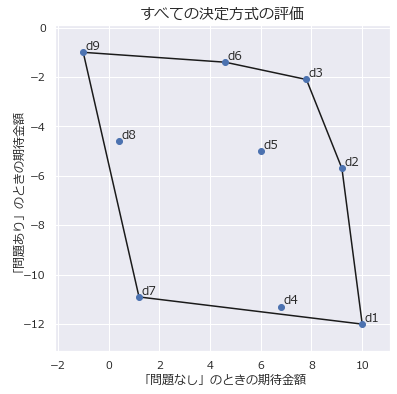

In [27]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(6, 6))

# 散布図とそれを囲む直線を描画
plot = convex_hull_plot_2d(hull, ax)

# 決定方式の名称のラベルを振る
for text, xy in risk_table_t.iterrows():
    ax.annotate(text, xy=xy, xytext=xy+0.1)

# グラフの装飾
ax.set_title('すべての決定方式の評価', fontsize=15)  # タイトル
ax.set_xlabel('「問題なし」のときの期待金額')        # X軸ラベル
ax.set_ylabel('「問題あり」のときの期待金額')        # Y軸ラベル

### 混合決定方式

In [28]:
# d2とd3決定方式の自然の状態別・決定方式別の期待金額
print(risk_table[['d2', 'd3']])

           d2   d3
問題なし  9.2  7.8
問題あり -5.7 -2.1


## セクション2：周辺分布P(θ)として判断確率を導入

### 検査情報がない場合の意思決定

#### 計算の方法の確認

In [29]:
# 「問題なし」の事前確率は0から1の範囲をとる
p_df = pd.DataFrame(np.array([np.arange(0, 1.01, 0.01), 
                              1 - np.arange(0, 1.01, 0.01)]))
p_df.index = payoff.index
print(p_df)

          0     1     2     3     4     5     6     7     8     9    ...  \
問題なし  0.0  0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  ...   
問題あり  1.0  0.99  0.98  0.97  0.96  0.95  0.94  0.93  0.92  0.91  ...   

           91    92    93    94    95    96    97    98    99   100  
問題なし  0.91  0.92  0.93  0.94  0.95  0.96  0.97  0.98  0.99  1.0  
問題あり  0.09  0.08  0.07  0.06  0.05  0.04  0.03  0.02  0.01  0.0  

[2 rows x 101 columns]


In [30]:
# 「出荷」という行動を選択したときの金額
payoff['出荷']

問題なし    10
問題あり   -12
Name: 出荷, dtype: int64

In [31]:
# 自然の状態の判断確率で重みづけられた金額
print(p_df.mul(payoff['出荷'], axis=0))

           0      1      2      3      4     5      6      7      8      9    \
問題なし   0.0   0.10   0.20   0.30   0.40   0.5   0.60   0.70   0.80   0.90   
問題あり -12.0 -11.88 -11.76 -11.64 -11.52 -11.4 -11.28 -11.16 -11.04 -10.92   

          ...   91    92    93    94   95    96    97    98    99    100  
問題なし  ...  9.10  9.20  9.30  9.40  9.5  9.60  9.70  9.80  9.90  10.0  
問題あり  ... -1.08 -0.96 -0.84 -0.72 -0.6 -0.48 -0.36 -0.24 -0.12  -0.0  

[2 rows x 101 columns]


In [32]:
# 自然の状態の判断確率における、金額の期待値
p_df.mul(payoff['出荷'], axis=0).sum(axis=0).head(3)

0   -12.00
1   -11.78
2   -11.56
dtype: float64

#### 効率的な実装

In [33]:
def make_emv_list(payoff):
    # 「問題あり」が発生する事前確率
    p_df = pd.DataFrame(np.array([np.arange(0, 1.01, 0.01), 
                                  1 - np.arange(0, 1.01, 0.01)]))
    p_df.index = payoff.index
    # 事前確率で重みづけられた期待金額
    emv = p_df.mul(payoff, axis=0).sum(axis=0)
    return(emv)

In [34]:
# 関数の動作確認
make_emv_list(payoff['出荷']).head(3)

0   -12.00
1   -11.78
2   -11.56
dtype: float64

In [35]:
# まとめて実行
no_data_emv = payoff.apply(make_emv_list)
print(no_data_emv.head(3))

    出荷  再検査  破棄
0 -12.00   -5.00  -1.0
1 -11.78   -4.89  -1.0
2 -11.56   -4.78  -1.0


#### 視覚的に最適行動を調べる

In [36]:
# 確率の列を入れる
no_data_emv_p = no_data_emv.copy()
no_data_emv_p.loc[:, 'p_theta'] = np.arange(0, 1.01, 0.01)
print(no_data_emv_p.head(3))

    出荷  再検査  破棄  p_theta
0 -12.00   -5.00  -1.0     0.00
1 -11.78   -4.89  -1.0     0.01
2 -11.56   -4.78  -1.0     0.02


Text(0, 0.5, '期待金額')

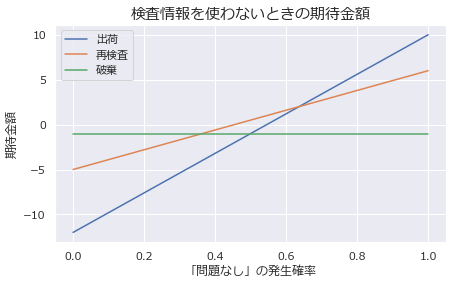

In [37]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 「問題なし」の発生確率を変化させたときの期待金額の折れ線グラフを描画
no_data_emv_p.plot(x='p_theta', ax=ax)

# グラフの装飾
ax.set_title('検査情報を使わないときの期待金額', fontsize=15)  # タイトル
ax.set_xlabel('「問題なし」の発生確率')                        # X軸ラベル
ax.set_ylabel('期待金額')                                      # Y軸ラベル

### 検査情報を使う場合の期待金額

In [38]:
# 再掲：許容的な決定方式であるd1、d2、d3、d6、d9の自然の状態別の期待金額
print(risk_table[admissible_decision])

            d1   d2   d3   d6   d9
問題なし  10.0  9.2  7.8  4.6 -1.0
問題あり -12.0 -5.7 -2.1 -1.4 -1.0


In [39]:
# 検査情報を使う場合の期待金額
use_data_emv = risk_table[admissible_decision].apply(make_emv_list)

In [40]:
# 確率の列を入れる
use_data_emv_p = use_data_emv.copy()
use_data_emv_p.loc[:, 'p_theta'] = np.arange(0, 1.01, 0.01)
print(use_data_emv_p.head(3))

      d1     d2     d3    d6   d9  p_theta
0 -12.00 -5.700 -2.100 -1.40 -1.0     0.00
1 -11.78 -5.551 -2.001 -1.34 -1.0     0.01
2 -11.56 -5.402 -1.902 -1.28 -1.0     0.02


Text(0, 0.5, '期待金額')

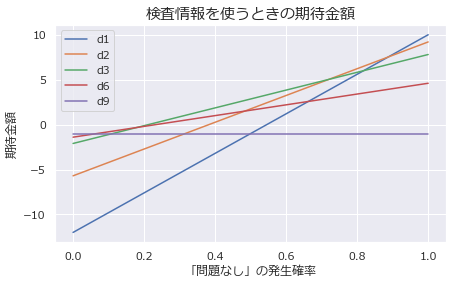

In [41]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 「問題なし」の発生確率を変化させたときの期待金額の折れ線グラフを描画
use_data_emv_p.plot(x='p_theta', ax=ax)

# グラフの装飾
ax.set_title('検査情報を使うときの期待金額', fontsize=15)  # タイトル
ax.set_xlabel('「問題なし」の発生確率')                    # X軸ラベル
ax.set_ylabel('期待金額')                                  # Y軸ラベル

### 検査情報がない場合の最適行動

#### 計算の方針の確認

In [42]:
# 期待金額が最も大きな選択肢を調べる
no_data_best_action = no_data_emv.idxmax(axis=1)
no_data_best_action.head(3)

0    破棄
1    破棄
2    破棄
dtype: object

In [43]:
# シフトする
no_data_best_action.shift(1).head(3)

0     NaN
1    破棄
2    破棄
dtype: object

In [44]:
# 最適行動が変わるp_thetaを調べる
no_data_act_change = no_data_best_action != no_data_best_action.shift(1)
no_data_act_change.head(3)

0     True
1    False
2    False
dtype: bool

#### 最適行動を調べる

In [45]:
# 最適行動の列を追加
no_data_emv_p.loc[:, 'best_action'] = no_data_best_action
# 最適行動が変わるp_thetaを抽出
print(no_data_emv_p.loc[no_data_act_change, ['p_theta', 'best_action']])

    p_theta best_action
0      0.00        破棄
37     0.37      再検査
64     0.64        出荷


### 検査情報がある場合の最適行動

In [46]:
# 期待金額が最も大きな決定方式を調べる
use_data_best_action = use_data_emv.idxmax(axis=1)
# 最適行動が変わるp_thetaを調べる
use_data_act_change = use_data_best_action != use_data_best_action.shift(1)
# 最適行動の列を追加
use_data_emv_p.loc[:, 'best_action'] = use_data_best_action
# 最適行動が変わるp_thetaを抽出
print(use_data_emv_p.loc[use_data_act_change, ['p_theta', 'best_action']])

    p_theta best_action
0      0.00          d9
7      0.07          d6
18     0.18          d3
72     0.72          d2
89     0.89          d1


In [47]:
# 参考。d1、d2、d3、d6、d9の行動方式の再掲
print(decision_func_set[admissible_decision])

                 d1      d2    d3      d6    d9
検査-問題なし  出荷    出荷  出荷  再検査  破棄
検査-問題あり  出荷  再検査  破棄    破棄  破棄


### 検査情報の価値

In [48]:
# 情報を使わないときの最大期待金額
no_data_best_emv = no_data_emv.max(axis=1)

# 情報を使うときの最大期待金額
use_data_best_emv = use_data_emv.max(axis=1)

# 情報の価値
evsi = use_data_best_emv - no_data_best_emv

Text(0, 0.5, '情報の価値')

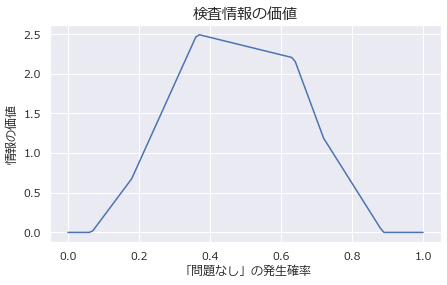

In [49]:
# X軸として使う、「問題なし」の発生確率
p_theta = np.arange(0, 1.01, 0.01)

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 情報の価値
ax.plot(p_theta, evsi, label='情報の価値')

# グラフの装飾
ax.set_title('検査情報の価値', fontsize=15)  # タイトル
ax.set_xlabel('「問題なし」の発生確率')      # X軸ラベル
ax.set_ylabel('情報の価値')                  # Y軸ラベル

## セクション3：判断確率を導入する際の、効率の良い計算方法

### 事後分布の計算

In [50]:
# 自然の状態にかんする条件付き分布P(z|θ)
print(conditional_state)

          検査-問題なし  検査-問題あり
問題なし            0.8            0.2
問題あり            0.1            0.9


In [51]:
# 自然の状態の周辺分布(事前分布)を与える
marginal_state = pd.Series({
    '問題なし':0.8,
    '問題あり':0.2,
})
marginal_state

問題なし    0.8
問題あり    0.2
dtype: float64

In [52]:
# ベイズの定理の分子：P(θ)・P(z|θ)
# すなわち同時分布を計算する
joint_information_state = conditional_state.mul(marginal_state, axis=0)
print(joint_information_state)

          検査-問題なし  検査-問題あり
問題なし           0.64           0.16
問題あり           0.02           0.18


In [53]:
# ベイズの定理の分母：P(z)
# すなわち情報の周辺分布を計算する
marginal_information = joint_information_state.sum(axis=0)
marginal_information

検査-問題なし    0.66
検査-問題あり    0.34
dtype: float64

In [54]:
# ベイズの定理に従って、情報にかんする条件付き分布P(θ|z)を計算
# 予測が得られた後の条件付き分布
conditional_information = joint_information_state.div(
    marginal_information, axis=1)
print(conditional_information)

          検査-問題なし  検査-問題あり
問題なし           0.97          0.471
問題あり           0.03          0.529


### 事後分布に基づく期待金額最大化

In [55]:
# 情報に関する条件付き分布P(θ|e)を使って
# 期待値を最大にする行動を選ぶ

In [56]:
# 最大値をとるインデックスを取得する。最大値が複数ある場合はすべて出力する。
def argmax_list(series):
    return(list(series[series == series.max()].index))

In [57]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
    emv = payoff_table.mul(probs, axis=0).sum()
    max_emv = emv.max()
    a_star = argmax_list(emv)
    return(pd.Series([a_star, max_emv], index=['選択肢', '期待金額']))

In [58]:
# ベイズ決定方式と、検査情報別の条件付きEMV
info_decision = \
    conditional_information.apply(max_emv, axis=0, payoff_table=payoff)
print(info_decision)

         検査-問題なし 検査-問題あり
選択肢          [出荷]      [再検査]
期待金額          9.33         0.176


In [59]:
# p_theta=0.8のときの最適な行動方式
print(use_data_emv_p.query('p_theta == 0.8')[['p_theta', 'best_action']])

    p_theta best_action
80      0.8          d2


In [60]:
# 行動方策「d2」
decision_func_set['d2']

検査-問題なし      出荷
検査-問題あり    再検査
Name: d2, dtype: object

In [61]:
# 参考：p_theta=0.8のときのEMV
print(use_data_emv_p.query('p_theta == 0.8')[['p_theta', 'best_action', 'd2']])

    p_theta best_action    d2
80      0.8          d2  6.22


In [62]:
# 参考：ベイズ決定の結果を情報の周辺分布で期待値を取った際のEMV
# これはp_theta=0.8のときのEMVに一致する
info_decision.loc['期待金額',].mul(marginal_information).sum()

6.220000000000002